# Отток клиентов

## Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. В наличии есть исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры. Довести метрику до 0.59. Проверить *F1*-меру на тестовой выборке самостоятельно.

Дополнительно вычислить *AUC-ROC*, и сравнить её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Описание данных

### Признаки

- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

### Целевой признак

- `Exited` — факт ухода клиента

## Подготовка данных

### Импорт необходимыx библиотек для работы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

RANDOM = 42  # значение random_state для моделирования
pd.options.mode.chained_assignment = None

###  Загружаем данные из файла `Churn.csv` в датафрейм `data`.

In [2]:
try:
    data = pd.read_csv("/datasets/Churn.csv")
except FileNotFoundError:
    data = pd.read_csv("https://code.s3.yandex.net/datasets/Churn.csv")

### Посмотрим правильность загрузки данных методом `head()` и информацию по дарафрейму методом `info()`

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Удалим столбцы `RowNumber`, `CustomerId` и `Surname`. 

- `RowNumber` повторяет индекс датафрейма - столбец получается лишним, 
- `CustomerId` - Id клиента-  никак не зависит от действий пользователя и не влияет на модели обучения,
- `Surname` - фамилия, то же никак не повлияет на уход из банка.

In [5]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

###  Приведем название столбцов к нижнему регистру

In [6]:
data.columns = data.columns.str.lower()

### Столбец `tenure`

В столбце `tenure` имеются пропуски. 909 пропущенныйх значений.

In [7]:
data['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [8]:
data['tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

Так как в столбце указано сколько лет человек является клиентом банка. Как видно из `value_counts()`. Значения распределены достаточно равномерно. Приблизительно одинаково по количству в зависимости от года. Заменять средним или медеинным значением будет некорретно. Проверим сооотношение выбывших клиентов к оставшимся для пропущенных и заполненных значений в столбце `tenure`.

In [9]:
len(data[(data['tenure'].isnull()) & (data['exited'] == 1)]) / len(
    data[(data['tenure'].isnull()) & (data['exited'] == 0)])

0.25206611570247933

In [10]:
len(data[(data['tenure'].isnull() == False) & (data['exited'] == 1)]) / len(
    data[(data['tenure'].isnull() == False) & (data['exited'] == 0)])

0.2561835014508774

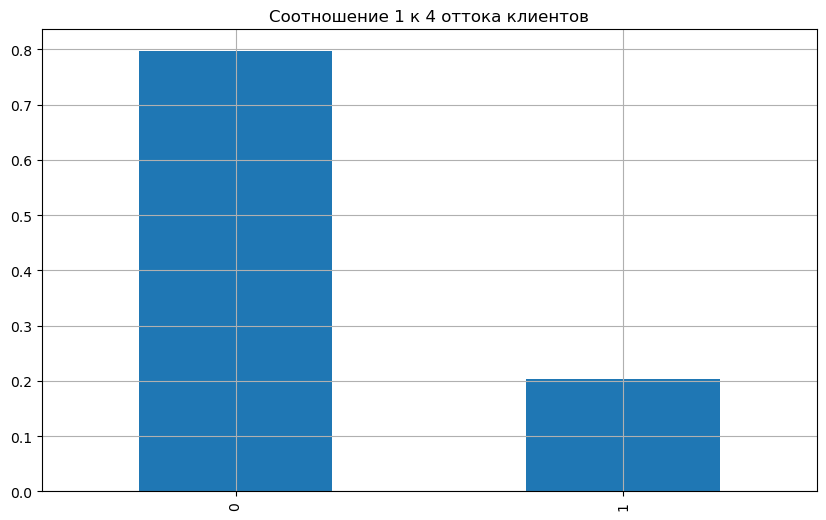

In [11]:
data['exited'].value_counts(normalize=True).plot(
    kind='bar',
    grid=True,
    figsize=(10, 6),
    title='Соотношение 1 к 4 оттока клиентов')
plt.show()

Соотношения одинаковые 1 к 4. Так как пропусков всего 9% и соотношения они не меняют их можно удалить.

In [12]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      9091 non-null   int64  
 1   geography        9091 non-null   object 
 2   gender           9091 non-null   object 
 3   age              9091 non-null   int64  
 4   tenure           9091 non-null   float64
 5   balance          9091 non-null   float64
 6   numofproducts    9091 non-null   int64  
 7   hascrcard        9091 non-null   int64  
 8   isactivemember   9091 non-null   int64  
 9   estimatedsalary  9091 non-null   float64
 10  exited           9091 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 852.3+ KB


Для уменьшения занимаемой оперативной памяти приведем типы данный к оптимальным и чуть чуть сократим занимаемую ОП.

- cтолбец `age` - все значение находятся в дипазоне до 127 , можно привести к типу `int8`,
- cтолбец `tenure` - всего 11 значений (от 0 до 10), можно привести к типу `int8`,
- cтолбец `numofproducts` - всего 4 значения (от 1 до 4), можно привести к типу `int8`,
- cтолбец `hascrcard` - всего 2 значения, можно привести к типу `int8`,
- cтолбец `isactivemember` - всего 2 значения, можно привести к типу `int8`,
- cтолбец `exited` - всего 2 значения, можно привести к типу `int8`.

In [13]:
data[[
    'age', 'tenure', 'numofproducts', 'hascrcard', 'isactivemember', 'exited'
]] = data[[
    'age', 'tenure', 'numofproducts', 'hascrcard', 'isactivemember', 'exited'
]].astype('int8')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      9091 non-null   int64  
 1   geography        9091 non-null   object 
 2   gender           9091 non-null   object 
 3   age              9091 non-null   int8   
 4   tenure           9091 non-null   int8   
 5   balance          9091 non-null   float64
 6   numofproducts    9091 non-null   int8   
 7   hascrcard        9091 non-null   int8   
 8   isactivemember   9091 non-null   int8   
 9   estimatedsalary  9091 non-null   float64
 10  exited           9091 non-null   int8   
dtypes: float64(2), int64(1), int8(6), object(2)
memory usage: 479.4+ KB


**Вывод** 

Данные подготовлены к исследованию. Удалены пропуски, оптимизированы типы данных (удалось высвободить почти 50% занимаемой ОП).

## Исследование задачи

### Избавляемся от категориальных признаков методом One hot encoder. 

Применим метод `get_dummies` и создадим новый датафрейм `data_ohe`

In [14]:
data_ohe = pd.get_dummies(data, drop_first=True)

### Cформируем датасеты для признаков и целевого признака.

Целевой признак `target` - столбец `exited`. 

Остальные столбцы будут являтся признаками - `features`.

In [15]:
target = data_ohe['exited']
features = data_ohe.drop(['exited'], axis=1)

### Разобъём данные на 3 выборки.

- обучающую, 
- валидационную,
- тестовую.

Размеры тестового и валидационного наборов обычно равны. Исходные данные разбиваем в соотношении 3:1:1 (60% : 20% : 20%)

Используем параметр `stratify` для распределение таргетов во всех новых датасетах.

In [16]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    train_size=0.6,
    test_size=0.4,
    random_state=RANDOM,
    stratify=target)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test,
    target_test,
    test_size=0.5,
    random_state=RANDOM,
    stratify=target_test)

**Проверяем разбиение на выборки**

In [17]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(5454, 11)
(5454,)
(1819, 11)
(1819,)
(1818, 11)
(1818,)


Исходный датасет разделили верно.

### Стандартизируем численные признаки методом `StandardScaler()`.

In [18]:
numeric = [
    'creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
    'isactivemember', 'estimatedsalary'
]
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### В исследовании несбалансированных данных будем проверять следующие модели машинного обучения:

- Решающее дерево,
- Случайный лес,
- Логистическая регрессия.

#### Решающее дерево.

Переберем варианты максимальной глубины дерева от 1 до 15 и найдем значение F1-меры.

In [19]:
best_model = None
best_f1 = 0
best_depth = 0

for depth in range(1, 16):
    model_tree = DecisionTreeClassifier(random_state=RANDOM, max_depth=depth)
    model_tree.fit(features_train, target_train)
    prediction_tree = model_tree.predict(features_valid)
    result_f1 = round(f1_score(target_valid, prediction_tree), 3)
    if best_f1 < result_f1:
        best_model = model_tree
        best_f1 = result_f1
        best_depth = depth

print(
    f'''Наилучшая F1 - мера {best_f1} в модели решающего леса достигается при глубине {best_model.max_depth}'''
)

Наилучшая F1 - мера 0.577 в модели решающего леса достигается при глубине 8


**Лучший результат F1 = 0.577 в модели решающего леса достигается при глубине 8**

#### Случайный лес. 

Переберем варианты максимальной глубины дерева от 1 до 15, количества деревьев от 1 до 40 и найдем значение F1-меры.

In [20]:
best_model_forest = None
best_f1_forest = 0
best_depth_forest = 0
best_estim_forest = 0

for depth in range(1, 16):
    for n_estim in range(1, 41):
        model_forest = RandomForestClassifier(random_state=RANDOM,
                                              max_depth=depth,
                                              n_estimators=n_estim)
        model_forest.fit(features_train, target_train)
        predictions_forest = model_forest.predict(features_valid)
        forest_f1 = round(f1_score(target_valid, predictions_forest), 3)
        if best_f1_forest < forest_f1:
            best_model_forest = model_forest
            best_f1_forest = forest_f1
            best_depth_forest = depth
            best_estim_forest = n_estim

print(
    f'''Наилучшая F1 мера - {best_f1_forest} в модели случайного леса достигается при глубине {best_model_forest.max_depth} и количестве деревьев {best_model_forest.n_estimators}'''
)

Наилучшая F1 мера - 0.583 в модели случайного леса достигается при глубине 10 и количестве деревьев 40


**Лучший результат F1 = 0.583 в модели случайного леса достигается при глубине 10 и количестве деревьев 40**

#### Логистическая регрессия.

In [21]:
model_regression = LogisticRegression(random_state=RANDOM, solver='liblinear')
model_regression.fit(features_train, target_train)
predictions_model_regression = model_regression.predict(features_valid)
f1_model_regression = round(
    f1_score(target_valid, predictions_model_regression), 3)

print('Максимальное F1:', f1_model_regression)

Максимальное F1: 0.321


**F1 = 0.321 в логистической регрессии.**

**Вывод**

В результате исследования несбалансированнных данных лучший результат показала модель случайного леса (Наилучшая F1 мера - 0.5832 в модели случайного леса достигается при глубине 10 и количестве деревьев 16)

## Борьба с дисбалансом

**Для борьбы с дисбалансом попробуем использовать 3 метода.**

- Взвешивание классов,
- Увеличение выборки (upsampling),
- Уменьшение выборки (downsampling).

Каждый из методов применим к трем моделям и найдем лучшее значение F1 меры.

### Балансировка классов

Придам объектам редкого класса 1 больший вес используя гиперпараметр `class_weight='balanced'`

#### Решающее дерево.

Переберем варианты максимальной глубины дерева от 1 до 15 и найдем значение F1-меры.

In [22]:
best_model_balance = None
best_f1_balance = 0
best_depth_balance = 0

for depth in range(1, 16):
    model_tree_balance = DecisionTreeClassifier(random_state=RANDOM,
                                                max_depth=depth,
                                                class_weight='balanced')
    model_tree_balance.fit(features_train, target_train)
    prediction_tree_balance = model_tree_balance.predict(features_valid)
    result_f1_balance = round(f1_score(target_valid, prediction_tree_balance),
                              3)
    if best_f1_balance < result_f1_balance:
        best_model_balance = model_tree_balance
        best_f1_balance = result_f1_balance
        best_depth_balance = depth

print(
    f'''Наилучшая F1 - мера {best_f1_balance} в модели решающего леса достигается при глубине {best_model_balance.max_depth}'''
)

Наилучшая F1 - мера 0.574 в модели решающего леса достигается при глубине 5


**Значение F1 чуть увеличилось до 0,574, но пока не дотягивается до необходимого..**

#### Случайный лес. 

Переберем варианты максимальной глубины дерева от 1 до 15, количества деревьев от 1 до 40 и найдем значение F1-меры.

In [23]:
best_model_forest_balance = None
best_f1_forest_balance = 0
best_depth_forest_balance = 0
best_estim_forest_balance = 0

for depth in range(1, 16):
    for n_estim in range(1, 41):
        model_forest_balance = RandomForestClassifier(random_state=RANDOM,
                                                      max_depth=depth,
                                                      n_estimators=n_estim,
                                                      class_weight='balanced')
        model_forest_balance.fit(features_train, target_train)
        predictions_forest_balance = model_forest_balance.predict(
            features_valid)
        forest_f1_balance = round(
            f1_score(target_valid, predictions_forest_balance), 3)
        if best_f1_forest_balance < forest_f1_balance:
            best_model_forest_balance = model_forest_balance
            best_f1_forest_balance = forest_f1_balance
            best_depth_forest_balance = depth
            best_estim_forest_balance = n_estim

print(
    f'''Наилучшая F1 мера - {best_f1_forest_balance} в модели случайного леса достигается при глубине {best_model_forest_balance.max_depth} и количестве деревьев {best_model_forest_balance.n_estimators}'''
)

Наилучшая F1 мера - 0.613 в модели случайного леса достигается при глубине 7 и количестве деревьев 19


**Значение F1 увеличилось до 0.613, но все равно другими методами можно попробовать его увеличить.**

#### Логистическая регрессия.

In [24]:
model_regression_balance = LogisticRegression(random_state=RANDOM,
                                              solver='liblinear',
                                              class_weight='balanced')
model_regression_balance.fit(features_train, target_train)
predictions_model_regression_balance = model_regression_balance.predict(
    features_valid)
f1_model_regression_balance = round(
    f1_score(target_valid, predictions_model_regression_balance), 3)

print('Максимальное F1:', f1_model_regression_balance)

Максимальное F1: 0.481


**И здесь значение F1 увеличилось до 0.481**

### Увеличение выборки (upsampling)

Напишем функцию upsampling

Преобразование проходит в несколько этапов:

- Разделить обучающую выборку на отрицательные и положительные объекты;
- Скопировать несколько раз положительные объекты;
- С учётом полученных данных создать новую обучающую выборку;
- Перемешать данные.

In [25]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled,
                                                   target_upsampled,
                                                   random_state=RANDOM)

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(features_train, target_train,
                                                5)

Переобучим наши модели на новых датасетах.

#### Решающее дерево.

Переберем варианты максимальной глубины дерева от 1 до 15 и найдем значение F1-меры.

In [26]:
best_model_unsampled = None
best_f1_unsampled = 0
best_depth_unsampled = 0

for depth in range(1, 16):
    model_tree_unsampled = DecisionTreeClassifier(random_state=RANDOM,
                                                  max_depth=depth)
    model_tree_unsampled.fit(features_upsampled, target_upsampled)
    prediction_tree_unsampled = model_tree_unsampled.predict(features_valid)
    result_f1_unsampled = round(
        f1_score(target_valid, prediction_tree_unsampled), 3)
    if best_f1_unsampled < result_f1_unsampled:
        best_model_unsampled = model_tree_unsampled
        best_f1_unsampled = result_f1_unsampled
        best_depth_unsampled = depth

print(
    f'''Наилучшая F1 - мера {best_f1_unsampled} в модели решающего леса достигается при глубине {best_model_unsampled.max_depth}'''
)

Наилучшая F1 - мера 0.556 в модели решающего леса достигается при глубине 7


**Значение F1 уменьшилось до 0.556**

#### Случайный лес. 

Переберем варианты максимальной глубины дерева от 1 до 15, количества деревьев от 1 до 40 и найдем значение F1-меры.

In [27]:
best_model_forest_unsampled = None
best_f1_forest_unsampled = 0
best_depth_forest_unsampled = 0
best_estim_forest_unsampled = 0

for depth in range(1, 16):
    for n_estim in range(1, 41):
        model_forest_unsampled = RandomForestClassifier(random_state=RANDOM,
                                                        max_depth=depth,
                                                        n_estimators=n_estim)
        model_forest_unsampled.fit(features_upsampled, target_upsampled)
        predictions_forest_unsampled = model_forest_unsampled.predict(
            features_valid)
        forest_f1_unsampled = round(
            f1_score(target_valid, predictions_forest_unsampled), 3)
        if best_f1_forest_unsampled < forest_f1_unsampled:
            best_model_forest_unsampled = model_forest_unsampled
            best_f1_forest_unsampled = forest_f1_unsampled
            best_depth_forest_unsampled = depth
            best_estim_forest_unsampled = n_estim

print(
    f'''Наилучшая F1 мера - {best_f1_forest_unsampled} в модели случайного леса достигается при глубине {best_model_forest_unsampled.max_depth} и количестве деревьев {best_model_forest_unsampled.n_estimators}'''
)

Наилучшая F1 мера - 0.606 в модели случайного леса достигается при глубине 14 и количестве деревьев 31


**А вот тут значение F1 уменьшилось до 0.606.**

#### Логистическая регрессия.

In [28]:
model_regression_unsampled = LogisticRegression(random_state=RANDOM,
                                                solver='liblinear')
model_regression_unsampled.fit(features_upsampled, target_upsampled)
predictions_model_regression_unsampled = model_regression_unsampled.predict(
    features_valid)
f1_model_regression_unsampled = round(
    f1_score(target_valid, predictions_model_regression_unsampled), 3)

print('Максимальное F1:', f1_model_regression_unsampled)

Максимальное F1: 0.474


**Значение F1 - 0.474...**

### Уменьшение выборки (downsampling)

Напишем функцию downsample

Преобразование проходит в несколько этапов:

- Разделить обучающую выборку на отрицательные и положительные объекты;
- Случайным образом отбросить часть из отрицательных объектов;
- С учётом полученных данных создать новую обучающую выборку;
- Перемешать данные. 

In [29]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RANDOM)] +
        [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RANDOM)] +
        [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled,
                                                       target_downsampled,
                                                       random_state=RANDOM)

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(features_train,
                                                      target_train, 0.1)

Переобучим наши модели на новых датасетах.

#### Решающее дерево.

Переберем варианты максимальной глубины дерева от 1 до 15 и найдем значение F1-меры.

In [30]:
best_model_downsampled = None
best_f1_downsampled = 0
best_depth_downsampled = 0

for depth in range(1, 16):
    model_tree_downsampled = DecisionTreeClassifier(random_state=RANDOM,
                                                    max_depth=depth)
    model_tree_downsampled.fit(features_downsampled, target_downsampled)
    prediction_tree_downsampled = model_tree_downsampled.predict(
        features_valid)
    result_f1_downsampled = round(
        f1_score(target_valid, prediction_tree_downsampled), 3)
    if best_f1_downsampled < result_f1_downsampled:
        best_model_downsampled = model_tree_downsampled
        best_f1_downsampled = result_f1_downsampled
        best_depth_downsampled = depth

print(
    f'''Наилучшая F1 - мера {best_f1_downsampled} в модели решающего леса достигается при глубине {best_model_downsampled.max_depth}'''
)

Наилучшая F1 - мера 0.538 в модели решающего леса достигается при глубине 4


**Значение F1 - 0.538**

#### Случайный лес. 

Переберем варианты максимальной глубины дерева от 1 до 15, количества деревьев от 1 до 40 и найдем значение F1-меры.

In [31]:
best_model_forest_downsampled = None
best_f1_forest_downsampled = 0
best_depth_forest_downsampled = 0
best_estim_forest_downsampled = 0

for depth in range(1, 16):
    for n_estim in range(1, 41):
        model_forest_downsampled = RandomForestClassifier(random_state=RANDOM,
                                                          max_depth=depth,
                                                          n_estimators=n_estim)
        model_forest_downsampled.fit(features_downsampled, target_downsampled)
        predictions_forest_downsampled = model_forest_unsampled.predict(
            features_valid)
        forest_f1_downsampled = round(
            f1_score(target_valid, predictions_forest_downsampled), 3)
        if best_f1_forest_downsampled < forest_f1_downsampled:
            best_model_forest_downsampled = model_forest_downsampled
            best_f1_forest_downsampled = forest_f1_downsampled
            best_depth_forest_downsampled = depth
            best_estim_forest_downsampled = n_estim

print(
    f'''Наилучшая F1 мера - {best_f1_forest_downsampled} в модели случайного леса достигается при глубине {best_model_forest_downsampled.max_depth} и количестве деревьев {best_model_forest_downsampled.n_estimators}'''
)

Наилучшая F1 мера - 0.591 в модели случайного леса достигается при глубине 1 и количестве деревьев 1


**Значение F1 уменьшилось до 0.591**

#### Логистическая регрессия.

In [32]:
model_regression_downsampled = LogisticRegression(random_state=RANDOM,
                                                  solver='liblinear')
model_regression_downsampled.fit(features_downsampled, target_downsampled)
predictions_model_regression_downsampled = model_regression_downsampled.predict(
    features_valid)
f1_model_regression_downsampled = round(
    f1_score(target_valid, predictions_model_regression_downsampled), 3)

print('Максимальное F1:', f1_model_regression_downsampled)

Максимальное F1: 0.416


**Значение F1 уменьшилось до 0.416**

### Выведем на экран все результаты полученных значений F1-меры в виде датафрейма

In [33]:
data_f1 = {
    'С дисбалансом классов': [best_f1, best_f1_forest, f1_model_regression],
    'Балансировка классов':
    [best_f1_balance, best_f1_forest_balance, f1_model_regression_balance],
    'Увеличение выборки (upsampling)': [
        best_f1_unsampled, best_f1_forest_unsampled,
        f1_model_regression_unsampled
    ],
    'Уменьшение выборки (downsampling)': [
        best_f1_downsampled, best_f1_forest_downsampled,
        f1_model_regression_downsampled
    ]
}

data_result = pd.DataFrame(
    data_f1,
    index=['Дерево решений', 'Случайный лес', 'Логистическая регрессия'])
data_result

,С дисбалансом классов,Балансировка классов,Увеличение выборки (upsampling),Уменьшение выборки (downsampling)
Дерево решений,0.577,0.574,0.556,0.538
Случайный лес,0.583,0.613,0.606,0.591
Логистическая регрессия,0.321,0.481,0.474,0.416


**Наилучшая модель - это случайный лес со значением F1 меры - 0.613  при глубине 7 и количестве деревьев 19 получена при балансировке классов с использованием гиперпараметра `class_weight='balanced'`**

### Построим ROC-кривую и посчитаем AUC-ROC и Accuracy лучшей модели.

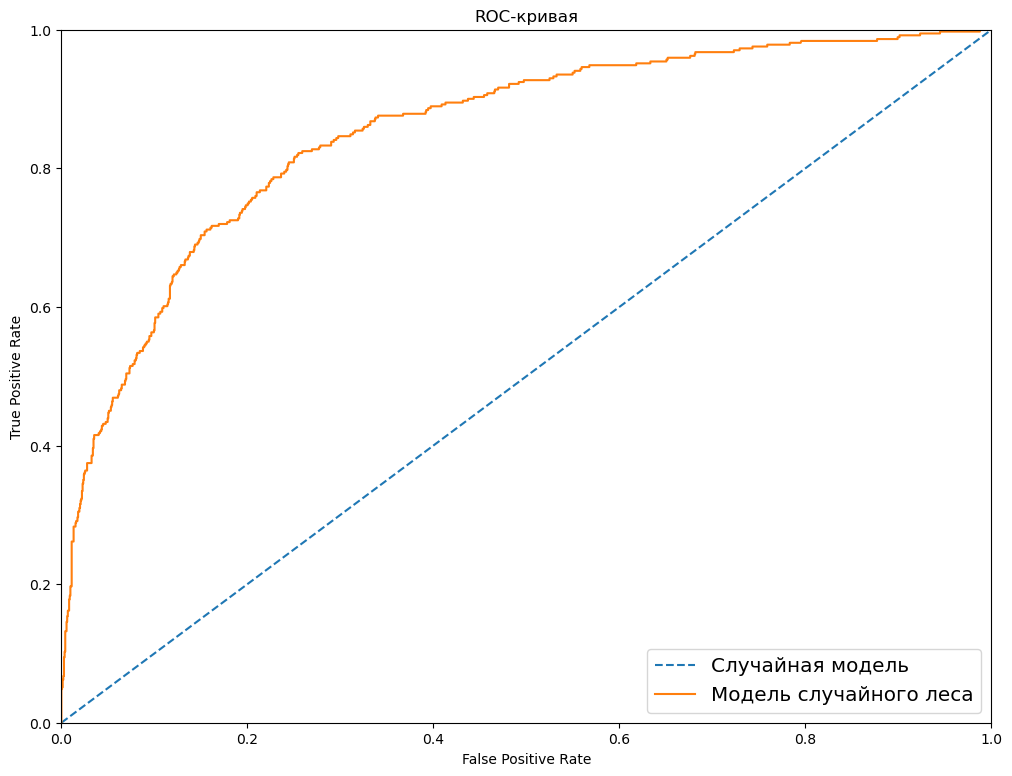

AUC-ROC модели случайного леса 0.853


In [34]:
plt.figure(figsize=[12, 9])

plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')

best_model_forest_balance = RandomForestClassifier(random_state=RANDOM,
                                                   max_depth=7,
                                                   n_estimators=19,
                                                   class_weight='balanced')
best_model_forest_balance.fit(features_train, target_train)
predictions_best_forest_balance = best_model_forest_balance.predict(
    features_valid)

probabilities_valid = best_model_forest_balance.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = round(roc_auc_score(target_valid, probabilities_one_valid), 3)

plt.plot(fpr, tpr, label='Модель случайного леса')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

print('AUC-ROC модели случайного леса', auc_roc)

## Тестирование модели

### Протестируем лучшую модель на тестовой выборке

In [35]:
model_forest_test = RandomForestClassifier(random_state=RANDOM,
                                           max_depth=7,
                                           n_estimators=19,
                                           class_weight='balanced')
model_forest_test.fit(features_train, target_train)
prediction_forest_test = model_forest_test.predict(features_test)
forest_f1_test = round(f1_score(target_test, prediction_forest_test), 6)
probabilities_valid_test = model_forest_test.predict_proba(features_test)
probabilities_one_valid_test = probabilities_valid_test[:, 1]
auc_roc_test = round(roc_auc_score(target_test, probabilities_one_valid_test),
                     6)

print('Значение F1 на тестовой выборке:', forest_f1_test)
print()
print('AUC-ROC на тестовой выборке:', auc_roc_test)

Значение F1 на тестовой выборке: 0.618705

AUC-ROC на тестовой выборке: 0.855435


**Значения F1, AUC-ROC увеличились**

### Попробуем переобучить модель тренировочной + валидационной выборке.

Объединим тренировочную и валидационную выборки и проверим на тестовой.

In [36]:
new_features_train = pd.concat((features_valid, features_train),
                               axis=0,
                               join='outer')
new_target_train = pd.concat((target_valid, target_train),
                             axis=0,
                             join='outer')

In [37]:
model_forest_new = RandomForestClassifier(random_state=RANDOM,
                                          max_depth=7,
                                          n_estimators=19,
                                          class_weight='balanced')
model_forest_new.fit(new_features_train, new_target_train)
predictions_model_forest_new = model_forest_new.predict(features_test)
f1_model_new = round(f1_score(target_test, predictions_model_forest_new), 3)
probabilities_valid_test_new = model_forest_new.predict_proba(features_test)
probabilities_one_valid_test_new = probabilities_valid_test_new[:, 1]
auc_roc_test_new = round(
    roc_auc_score(target_test, probabilities_one_valid_test_new), 3)
print('F1 на тестовой выборке:', f1_model_new)
print('AUC-ROC на тестовой выборке:', auc_roc_test_new)

F1 на тестовой выборке: 0.597
AUC-ROC на тестовой выборке: 0.855


**Здесь не удалось добиться увеличения F1-меры**

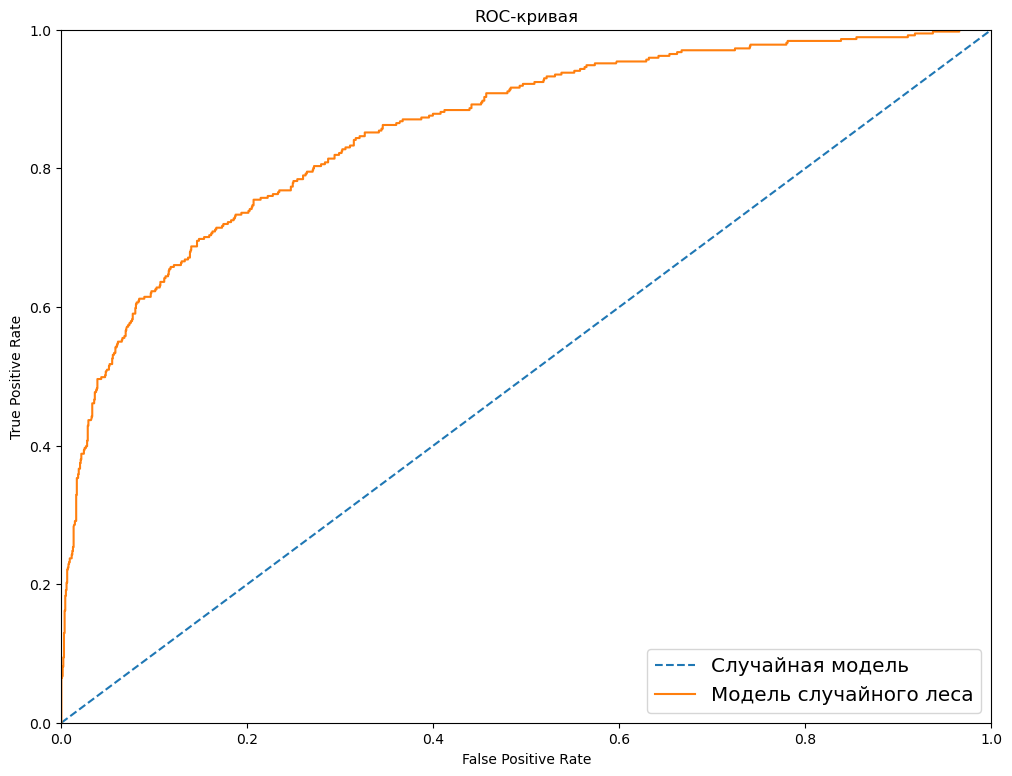

In [38]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')

model_forest_test_final = RandomForestClassifier(random_state=RANDOM, max_depth=8, n_estimators=14, class_weight='balanced')
model_forest_test_final.fit(new_features_train, new_target_train)

probabilities_valid_final = model_forest_test_final.predict_proba(features_test)
probabilities_one_valid_final = probabilities_valid_final[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid_final)

plt.plot(fpr, tpr, label='Модель случайного леса')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()


## Общий вывод

В результате исследования были обучены три модели:

- Решающее дерево,
- Случайный лес,
- Логистическая регрессия.

Поиск лучшего значения проводился четырьмя этапами:

1. Обучение с дисбалансом классов.
2. С балансированием классов.
3. Увеличением выборки.
4. Уменьшением выборки.

Лучшей моделью оказалась - модель случайного леса ( при глубине 7 и количестве деревьев 19), обученнная при балансировке классов.
Полученное значение *F1-меры* - 0.613, что соответветсвует требуемому пороговому значению в 0.59.

При проверке на тестовой выборке модель показала увеличение значения *F1-меры* до 0.618705 и при дополнительном обучении модели на тренировочной + валидационной выборке не удалось увеличить значение *F1-меры*.

*AUC-ROC* на тестовой выборке: 0.855435